#  医学中的人工智能-CADD练习

## 目标

通过03_Al Drug Discovery & Design -> 01_Compound_data_acquisition机器学习对表皮生长因子受体（[EGFR] 的抑制剂进行虚拟筛选实验。首先，将引入计算机友好的分子表示，允许机器学习模型的训练。接下来，将训练一个支持载体机，将分子分类为活性或非活性分子。训练有素的模型将用于预测小分子集的活性。最后，成功的参与者可以通过在线资源检查他们针对EGFR的潜在活动。

## Python软件包
- [scikit-learn](https://scikit-learn.org/stable/)
- [rdkit](https://www.rdkit.org/)
- [pandas](https://pandas.pydata.org/)
- [numpy](https://numpy.org/)
- [matplotlib](https://matplotlib.org/)

## Practical

**内容**

1.安装RDKit

2.导入模块

3.数据提供

3.1 加载数据

3.2 解释分子

4.分类数据

5.拆分数据

6.训练一个支持向量分类器

7.评估绩效

8.使用未被解的分子

### 1.安装RDKit

RDKit未安装在Google Colab中，RDKit仅通过“conda”（软件包管理器）提供，Colab上也不可用。要提供RDKit，我们需要（1）安装conda（我们将使用“condacolab”）和（2）使用“mamba”安装RDKit。

In [ ]:
!pip install condacolab
import condacolab
condacolab.install()

In [ ]:
!mamba install -yq rdkit

### 2.导入模块

执行此练习的所有部分都需要这些模块。随意添加其他模块，因为有多种解决方案可以成功。

In [6]:
#data handling
import numpy as np
import pandas as pd

# chemistry
from rdkit import Chem
from rdkit.Chem import MACCSkeys
from rdkit.Chem.Draw import IPythonConsole, rdMolDraw2D

# machine learning
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# plotting
import matplotlib.pyplot as plt

In [3]:
from pathlib import Path
import os

# 获取当前工作目录
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)

/Users/wangyang/Desktop/AI-drug-design/list/00_ai_in_medicine/data


### 3. Data preparation

#### 3.1 加载数据

我们将使用从[ChEMBL]数据库中检索的分子子集，该数据库包含约约5k分子，报告了针对EGFR的活性。整个ChEMBL数据库目前包含约1600万个数据点，用于约200万种化合物。

***插入代码，将`data/egfr_chembl25.csv`中发现的数据加载到名为“df”的pandas数据框架中，并显示前几行。***

In [10]:
# Read activity data for EGFR into a pandas dataframe named df
egfr_chembl25_link = pd.read_csv(DATA / 'egfr_chembl25.csv')

该数据帧包含有关ChEMBL ID的信息，可用于查询ChEMBL数据库、SMILES字符串形式的分子和nM形式的IC50形式的活性值。半数抑制浓度( IC50 )是指在体外实验中产生50 %抑制率的摩尔浓度。

#### 3.2 解释分子

接下来，我们将解释存储为SMILES字符串的分子，并将其转换为机器学习算法可以处理的格式。[RDKit]库是一个免费的开源框架，可用于处理分子数据。在以下单元格中，您将学习RDKit的一些基本功能，以及如何在计算机友好的位向量中存储分子子结构，这些子结构以后可用于训练您的模型。

In [15]:
egfr_chembl25_link.head()

,chembl_id,smiles,IC50[nM]
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,77.00
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,330.00
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,1.00
3,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,40.00
4,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,43000.01


In [16]:

df = pd.read_csv(DATA / 'egfr_chembl25.csv')

Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1


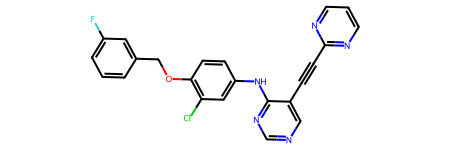

In [17]:
# 挑选数据中存储的第一个SMILES，用RDKit显示分子
print(df['smiles'][0])
mol = Chem.MolFromSmiles(df['smiles'][0])
mol

SMILES（**S**implified **M**olecular **I**nput **L**ine **E**ntry **S**ystem）表示法允许将原子的类型和连接性存储在一个单独的字符串中。
 - **原子类型**  由它们的原子符号表示，大写字母代表脂肪族原子，小写字母代表芳香族原子，氢原子通常被省略，因为可以从原子类型和连接性推断出来：
- C - 烯丙基（sp3）碳
- n - 芳香族（sp2）氮
- **Bonds**   只在需要时才表示：
- - - 单键（`CC` 和 `C-C` 相同，因为单键默认使用）
- `=` - 双键（`C=C-C=C` 和 `cccc` 相同）
- `#` - 三键
- **环** 开启和闭合用数字表示：
- 苯
- **取代基**  留下链条或环用括号表示：
- c1cc(C)ccc1 - 甲基取代苯。
-  CC(F)(Br)Cl - 以氟、氯和溴取代的乙烷

* *根据上述规则，您应该能够创建阿司匹林活性成分乙酰水杨酸的SMILES。* *

<img src='images/aspirin.png'>

2D representation of acetylsalicylic acid taken from [Wikipedia](https://en.wikipedia.org/wiki/Aspirin#/media/File:Aspirin-skeletal.svg).

## 分子可以以[分子指纹],将子结构的存在存储在一个由01组成的比特向量中。在这里我们将使用分子ACCess系统( MACCS ))键的形式表示，在RDKit中实现，并记录预定义的子结构集合的存在。

In [18]:
maccs_keys = list(MACCSkeys.GenMACCSKeys(mol))
print(maccs_keys)
print('Zeros:', len(maccs_keys) - sum(maccs_keys))
print('Ones:', sum(maccs_keys))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0]
Zeros: 129
Ones: 38


让我们来探究在我们的样品分子中可以找到哪些子结构。

In [19]:
# 获得指标
maccs_key_series = pd.Series(maccs_keys)
maccs_key_series[maccs_key_series==1].index

Int64Index([ 17,  38,  42,  65,  77,  80,  87,  98, 103, 107, 109, 113, 120,
            121, 125, 126, 127, 133, 134, 135, 137, 142, 143, 144, 145, 150,
            151, 152, 153, 155, 156, 157, 158, 161, 162, 163, 164, 165],
           dtype='int64')

底层子结构通过字典在RDKit中提供，并表示为[ SMARTS ]，它是SMILES语言的扩展，特别适用于子结构搜索。位80的SMARTS表示子结构' [ # 7 ] ~ * ~ * ~ * ~ [ # 7 ] '。
- `#7` - any nitrogen
- `~` - any bond
- `*` - any atom

我们还可以用下面的线条来可视化子结构。只需用上面找到的任何一个索引替换" bit _ index "。

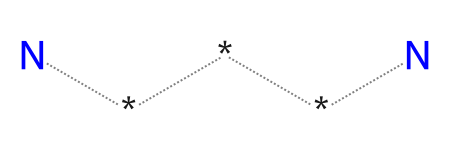

In [20]:
bit_index = 80
smarts = MACCSkeys.smartsPatts[bit_index][0]
Chem.MolFromSmarts(smarts)

接下来，我们使用下面的函数为数据集中的每个SMILES添加一个RDKit表示和MACCS密钥。

In [22]:
def add_mols_and_maccs(df, smiles_column='smiles'):
    """
    生成rdkit分子对象和MACCSkey，并将其添加到给定的数据框架中。
    
    Parameters
    ----------
    df: pandas.DataFrame
        A data frame containing a column with SMILES.
    """
    df['mol'] = df[smiles_column].apply(Chem.MolFromSmiles)
    df['maccs'] = df['mol'].apply(MACCSkeys.GenMACCSKeys)
    return

In [23]:
# 为rdkit分子添加列和maccs键
add_mols_and_maccs(df)
display(df.head())

,chembl_id,smiles,IC50[nM],mol,maccs
0,CHEMBL207869,Clc1c(OCc2cc(F)ccc2)ccc(Nc2c(C#Cc3ncccn3)cncn2)c1,77.00,<rdkit.Chem.rdchem.Mol object at 0x7fdd0247ca00>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CHEMBL3940060,ClCC(=O)OCCN1C(=O)Oc2c1cc1c(Nc3cc(Cl)c(F)cc3)n...,330.00,<rdkit.Chem.rdchem.Mol object at 0x7fdd0247cfa0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CHEMBL3678951,FC(F)(F)c1cc(Nc2n(C(C)C)c3nc(Nc4ccc(N5CC[NH+](...,1.00,<rdkit.Chem.rdchem.Mol object at 0x7fdd0247cbe0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL504034,Clc1c(OCc2cc(F)ccc2)ccc(Nc2ncnc3c2sc(C#C[C@H]2...,40.00,<rdkit.Chem.rdchem.Mol object at 0x7fdd0247c820>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL158797,S(Sc1n(C)c2c(c1C(=O)NCC(O)CO)cccc2)c1n(C)c2c(c...,43000.01,<rdkit.Chem.rdchem.Mol object at 0x7fdd0ada2820>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


#### 4。对数据进行分类
为了训练一个机器学习模型将分子分类为有活性或无活性，我们需要在我们的数据集中添加一个活性标签。
- 在下面的代码中，如果IC50低于500，否则为0.0，则在数值为1.0的数据框中添加一个名为" active "的列。

In [27]:
# Mark every molecule as active with an IC50 < 500
df['active'] = (df['IC50[nM]'] < 500).astype(float)

#### 5. 拆分数据

The following lines should find 2762 actives and 2147 inactives.

In [28]:
print('Actives:', int(df['active'].sum()))
print('Inactives:', int(len(df)-df['active'].sum()))

Actives: 2762
Inactives: 2147


### 5. Split data

***Split the data into training and test set by using the [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.***

In [30]:
# specify features and label
x, y = df['maccs'].to_list(), df['active'].to_list()
# Split the features and labels into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### 6. Train a support vector classifier


In [31]:
# train model
model = SVC(kernel='linear', C=1.0, random_state=42)
model.fit(x_train, y_train)

SVC(kernel='linear', random_state=42)

### 7. Assess performance   



In [32]:
# predict the activity of the test set
y_pred = model.predict(x_test)

#### 8. Use unexplored molecules

***Use your model and predict the activity of a set of unknown molecules located at*** `data/egfr_candidates.csv`***.***

### 7. Assess performance

- ***[predict](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC.predict) the activity of the test set***  
- ***assess the performance of your model by plotting a [ROC curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) and calcuation of the [AUC](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html)***

In [33]:
# predict the activity of the test set
y_pred = model.predict(x_test)
####################

####################

In [34]:
# calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC:', auc)

AUC: 0.7879133313067855




####################

####################

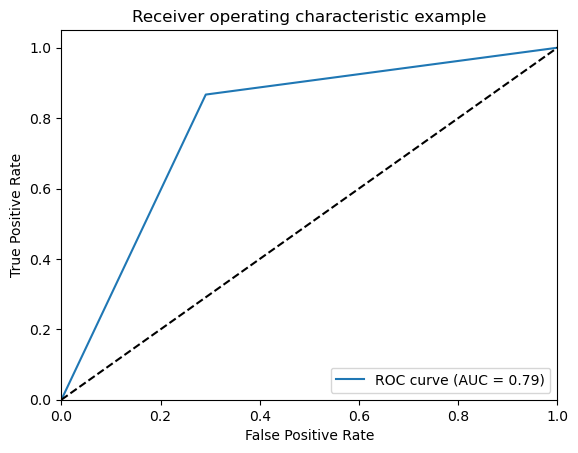

In [35]:
# plot the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

####################

####################